# Preprocessing 
#### This file includes preprocessing steps and their plots for sleep stage classification.

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

## Imports and Loading

In [1]:
import pandas as pd
import numpy as np
from loader import *
import matplotlib.pyplot as plt
from constants import *
from plot import *
from helpers import *

In [2]:
subjectID = PARTICIPANT_IDS[5]
len(PARTICIPANT_IDS)

49

In [3]:
sleep_stages = read_patient_data(subjectID)

In [4]:
sleep_stages.head()

,sleep_stage_num_somnofy,sleep_stage_num_emfit,sleep_stage_num_psg
timestamp_local,,,
2021-09-15 21:48:30+00:00,2.0,2.0,2.0
2021-09-15 21:49:00+00:00,2.0,2.0,2.0
2021-09-15 21:49:30+00:00,2.0,2.0,2.0
2021-09-15 21:50:00+00:00,2.0,2.0,2.0
2021-09-15 21:50:30+00:00,2.0,2.0,2.0


<AxesSubplot:xlabel='timestamp_local'>

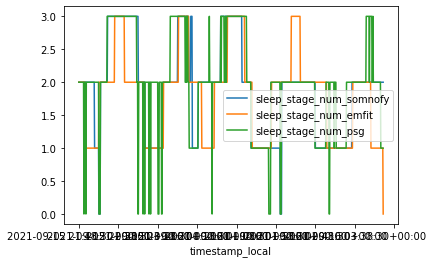

In [5]:
sleep_stages.plot()

In [6]:
sleep_stages.isna().sum()

sleep_stage_num_somnofy    0
sleep_stage_num_emfit      0
sleep_stage_num_psg        0
dtype: int64

Somnofy is missing where psg has the following values:
[]


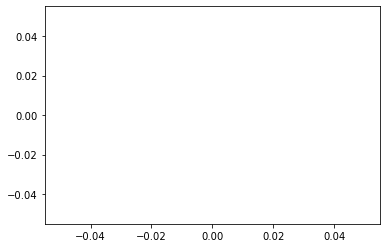

In [7]:
"""
1 -> missing values of radar
2 -> missing values of mat
3 -> missing values of psg
"""
plot_missing_sleepstages(sleep_stages)

## Imputing missing values
Comparison of three main techniques for time series data:
1. coping the previous or future value
2. having a rolling average and rounding it
3. Interpolation with "linear", "spline", "time", "quadratic"

In [8]:
df = pd.DataFrame()
df["somnofy"] = sleep_stages["sleep_stage_num_somnofy"]
df["truth"] = sleep_stages["sleep_stage_num_psg"]
df["Forward Fill"] = df["somnofy"].ffill()
df["Backward Fill"] = df["somnofy"].bfill()

<AxesSubplot:xlabel='timestamp_local'>

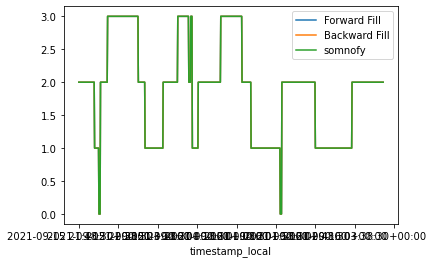

In [9]:
df[["Forward Fill", "Backward Fill", "somnofy"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

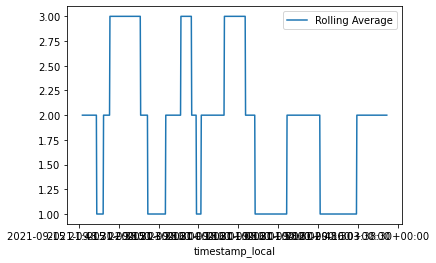

In [10]:
df["Rolling Average"] = df["somnofy"].rolling(window=10).mean().round()
df[["Rolling Average"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

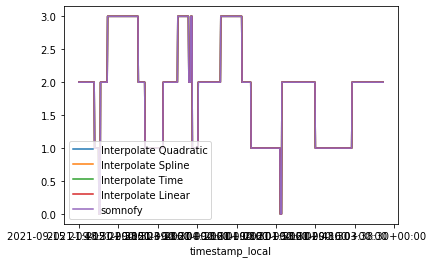

In [11]:
df["Interpolate Spline"]= df["somnofy"].interpolate(option='spline').round()
df["Interpolate Linear"]= df["somnofy"].interpolate(option='linear').round()
df["Interpolate Time"]= df["somnofy"].interpolate(option='time').round()
df["Interpolate Quadratic"]= df["somnofy"].interpolate(option='quadratic').round()
df[["Interpolate Quadratic", "Interpolate Spline", "Interpolate Time", "Interpolate Linear", "somnofy"]].plot()

In [12]:
# no difference between interpolation methods
diff = np.ones(3)
diff[0] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='linear'))
diff[1] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='time'))
diff[2] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='quadratic'))
diff

array([0., 0., 0.])

array([15.84297952, 15.84297952, 15.84297952])

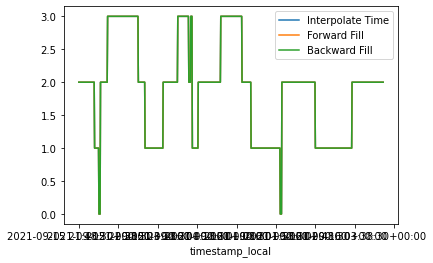

In [13]:
# decide which is best based on ground truth
df[["Interpolate Time", "Forward Fill", "Backward Fill"]].plot()
diff = np.ones(3)
diff[0] = np.linalg.norm(df["Interpolate Time"]-df["truth"].interpolate(option='time').round())
diff[1] = np.linalg.norm(df["Forward Fill"]-df["truth"].ffill())
diff[2] = np.linalg.norm(df["Backward Fill"]-df["truth"].ffill())
diff

In [14]:
# test_imputing()

In [15]:
# impute_all()

### Generate CNN Input

In [16]:
patients = []
lens = []
for subjectId in PARTICIPANT_IDS:
    sleep_stages = read_patient_data(subjectId)
    patients.append(sleep_stages)
    lens.append(sleep_stages.shape[0])
print(lens)

[931, 818, 1180, 843, 748, 773, 667, 888, 754, 910, 772, 670, 1319, 695, 1115, 1064, 1031, 635, 783, 561, 864, 839, 793, 704, 632, 679, 888, 1144, 656, 1095, 703, 1491, 592, 752, 1173, 782, 694, 1064, 719, 647, 1269, 774, 1308, 1051, 656, 719, 668, 651, 862]


In [17]:
print("MIN: ", min(lens))
print("MAX: ", max(lens))
print("MEAN: ", np.mean(lens))
print("STD: ", np.std(lens))

MIN:  561
MAX:  1491
MEAN:  857.6734693877551
STD:  218.32791175483874


In [18]:
mean = int(np.mean(lens))
less_data = [a for a in patients if len(a) < mean]
lens_less = [len(a) for a in less_data]
more_data = [a for a in patients if len(a) >= mean]
lens_more = [len(a) for a in more_data]

In [19]:
print("Less data: ", min(lens_less), max(lens_less), np.mean(lens_less), np.std(lens_less), len(lens_less))
print("More data: ", min(lens_more), max(lens_more), np.mean(lens_more), np.std(lens_more), len(lens_more))

Less data:  561 843 712.6333333333333 70.2991148988062 30
More data:  862 1491 1086.6842105263158 171.65695675772682 19


In [20]:
radars, mats, patients = get_nn_patients()
print(radars.shape)
print(mats.shape)
print(patients.shape)

(49, 857)
(49, 857)
(49, 857, 3)
